### Implementing simple neural network from scratch
In this notebook I implemented a simple neural network without using advanced ML libraries.


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from common import *
import pickle

In [22]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward_pass(self, input):
        raise NotImplementedError

    def backpropagation(self, output_error, learning_rate):
        raise NotImplementedError


class FullyConnectedLayer(Layer):
    def __init__(self, input_size, output_size, init_method="random"):
        if init_method == "random":
            self.weights = np.random.rand(input_size, output_size) - 0.5
            self.bias = np.random.rand(1, output_size) - 0.5
        elif init_method == "zeros":
            self.weights = np.zeros((input_size, output_size))
            self.bias = np.zeros((1, output_size))
        elif init_method == "xavier":
            self.weights = np.random.randn(input_size, output_size) * np.sqrt(
                2 / (input_size + output_size)
            )
            self.bias = np.random.randn(1, output_size) * np.sqrt(
                2 / (input_size + output_size)
            )
        elif init_method == "he":
            self.weights = np.random.randn(input_size, output_size) * np.sqrt(
                2 / input_size
            )
            self.bias = np.random.randn(1, output_size) * np.sqrt(2 / input_size)

    def forward_pass(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    def backpropagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)

        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error


class ActivationComponent(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward_pass(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    def backpropagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error


class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None
        self.convergence = []

    def save(self, filename):
        with open(filename, "wb") as f:
            pickle.dump(self, f)

    def add(self, layer):
        self.layers.append(layer)

    def set_loss(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    def predict(self, input_data):
        samples = len(input_data)
        result = []
        for i in range(samples):
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_pass(output)
            result.append(output)

        return result

    def fit(self, x_train, y_train, epochs, learning_rate, printc=False):
        samples = len(x_train)
        for i in range(epochs):
            err = 0
            for j in range(samples):
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_pass(output)
                err += self.loss(y_train[j], output)

                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backpropagation(error, learning_rate)

            err /= samples
            self.convergence.append(err)
            if printc:
                print(f"Epoch: {i}, Error: {err}")

In [23]:
# load mnist data
x_train, y_train = load_mnist("mnist", kind="train")
x_test, y_test = load_mnist("mnist", kind="t10k")

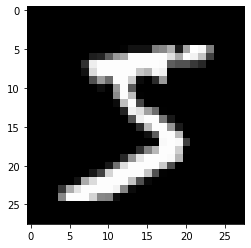

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [24]:
# display an image from the training set
plt.imshow(x_train[0].reshape(28, 28), cmap="gray")
plt.show()
# convert to one-hot encoding
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]
print(y_test[0])

In [26]:
mnist_net = Network()
mnist_net.add(FullyConnectedLayer(784, 128, "random"))
mnist_net.add(ActivationComponent(tanh, tanh_prime))
mnist_net.add(FullyConnectedLayer(128, 64, "random"))
mnist_net.add(ActivationComponent(tanh, tanh_prime))
mnist_net.add(FullyConnectedLayer(64, 10, "random"))
mnist_net.add(ActivationComponent(softmax, softmax_prime))
mnist_net.set_loss(cross_entropy, cross_entropy_prime)
mnist_net.fit(x_train, y_train, epochs=20, learning_rate=0.001, printc=True)
#save the model
mnist_net.save("mnist_net.pkl")

Epoch: 0, Error: 0.16579311006132258
Epoch: 1, Error: 0.17918881731724318


KeyboardInterrupt: 

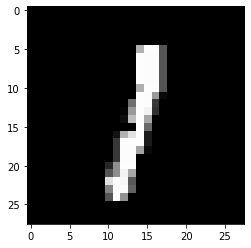

Prediction: 6


In [ ]:
# load the network
with open("mnist_net.pkl", "rb") as f:
    mnist_net = pickle.load(f)
# get random image from the test set
idx = np.random.randint(len(x_test))
img = x_test[idx]
plt.imshow(img.reshape(28, 28), cmap="gray")
plt.show()

# get the prediction
prediction = np.argmax(mnist_net.predict(img.reshape(1, 784)))
print(f"Prediction: {prediction}")